In [1]:
!pip3 install numba
from numba import jit
import numpy as np
from numpy.random import *
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
nx = 500
ny = nx
nsteps = 3000
nout = 100
dt = 3.0e-7
dx = 4.0e-8
dy = dx
pi = 3.141592
lheat_A = 2.350e+9 # latent heat of Ni [J/m3]
lheat_B = 1.728e+9
Tm_A = 1728.0 # melting temperature of Ni [K]
Tm_B = 1358.0
gamma_A = 0.37 # interfacial energy [J/m2]
gamma_B = 0.29
kinetic_A = 0.0033 # kinetic coefficient [m/K/s]
kinetic_B = 0.0039
D_L = 1.0e-9 # diffusion coefficient in liquid [m2/s]
D_S = 1.0e-13
vmol = 7.4e-6
rgas = 8.31451
ani_mode = 4. # mode number of interfacial anisotropy
ani_str = 0.04 # strength of interfacial anisotropy (must be smaller than 1/((ani_mode)^2-1)
mag_noise = 0.1 # magnitude of noise
thet0 = 0.*pi/180.
init_con = 0.4083 # initial concentration in liquid
init_temp = 1574. # initial temperature [K]
delta = 6.0*dx # interfacial thickness [m]
lamda = 0.1
bbb = 2.*np.log((1.+(1.-2.*lamda))/(1.-(1.-2.*lamda)))/2.
tinb = gamma_A/gamma_B*Tm_B/Tm_A*delta
eps = np.sqrt(3.*delta*gamma_A/(bbb*Tm_A)) # gradient energy coefficient
W_A = 6.*gamma_A*bbb/(delta*Tm_A) # double-well potential height
W_B = 6.*gamma_B*bbb/(tinb*Tm_B)
M_A = bbb*Tm_A*Tm_A*kinetic_A/(3.*delta*lheat_A) # mobility of phase-field
M_B = bbb*Tm_B*Tm_B*kinetic_B/(3.*tinb*lheat_B)

In [3]:
p_t = np.zeros((nx,ny)) # phase-field variable at time t
p_tdt = np.zeros((nx,ny)) # phase-field variable at time t+dt
c_t = np.zeros((nx,ny)) # concentration variable at time t
c_tdt = np.zeros((nx,ny)) # concentration variable at time t+dt
dpx = np.zeros((4,nx,ny))
dpy = np.zeros((4,nx,ny))
dcx = np.zeros((4,nx,ny))
dcy = np.zeros((4,nx,ny))

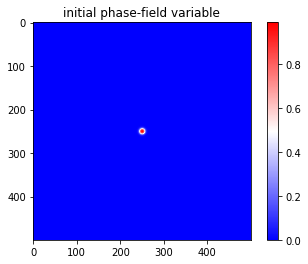

In [7]:
r0 = 6.*dx

for i in range(        p_t[i,j] = 0.0
        x = dx*(i-nx/2)
        y = dy*(j-ny/2)
        r = np.sqrt(x*x + y*y)
        p_t[i,j] = 0.5*(1.-np.tanh(np.sqrt(2.*W_A)/(2.*eps)*(r-r0)))
        if p_t[i,j] <= 1.0e-5:
            p_t[i,j] = 0.0
0,nx):
    for j in range(0,ny):
        c_t[i,j] = init_con

plt.imshow(p_t, cmap='bwr')
plt.title('initial phase-field variable')
plt.colorbar()
plt.show()

In [8]:
@jit
def  calc_gradient(o_t,dox,doy):
    for i in range(nx):
        for j in range(ny):
            ip = i + 1
            im = i - 1
            jp = j + 1
            jm = j - 1
            if ip > nx-1:
                ip = nx-1
            if im < 0:
                im = 0
            if jp > ny-1:
                jp = ny-1
            if jm < 0:
                jm = 0  
            dox[0,i,j]=(o_t[ip,j ]-o_t[i ,j ])/dx
            dox[1,i,j]=(o_t[i ,j ]-o_t[im,j ])/dx
            dox[2,i,j]=(o_t[ip,j ]+o_t[ip,jp]-o_t[im,j ]-o_t[im,jp])/(4.*dx)
            dox[3,i,j]=(o_t[ip,j ]+o_t[ip,jm]-o_t[im,j ]-o_t[im,jm])/(4.*dx)
            doy[0,i,j]=(o_t[i ,jp]+o_t[ip,jp]-o_t[i ,jm]-o_t[ip,jm])/(4.*dy)
            doy[1,i,j]=(o_t[i ,jp]+o_t[im,jp]-o_t[i ,jm]-o_t[im,jm])/(4.*dy)
            doy[2,i,j]=(o_t[i ,jp]-o_t[i ,j ])/dy
            doy[3,i,j]=(o_t[i ,j ]-o_t[i ,jm])/dy

In [9]:
@jit
def solve_allen_cahn(p_t, c_t, dpx, dpy, p_tdt):
    for i in range(0,nx):
        for j in range(0,ny):

            phi = p_t[i,j]
            con = c_t[i,j]
            q_phi   = phi*phi*(1.-phi)*(1.-phi) # double-well potential function
            dq_phi  = 30.*q_phi
            ddouble_A = W_A*2.*phi*(1.-phi)*(1.-2.*phi)
            ddouble_B = W_B*2.*phi*(1.-phi)*(1.-2.*phi)
            H_A  = ddouble_A+dq_phi*lheat_A*(init_temp-Tm_A)/(init_temp*Tm_A)
            H_B  = ddouble_B+dq_phi*lheat_B*(init_temp-Tm_B)/(init_temp*Tm_B)

            epss = np.zeros((4))
            epsd = np.zeros((4))
            for k in range(4):
                ddpx=dpx[k,i,j]
                ddpy=dpy[k,i,j]
                ddp_t=np.sqrt(ddpx**2+ddpy**2)
                if ddpx == 0. and ddpy == 0. :
                    thet=0. # angle of interface normal vector
                else:
                    tcos=-ddpx/ddp_t
                    tsin=-ddpy/ddp_t
                    if tsin >= 0.:
                        thet=np.arccos(tcos)
                    if tsin <= 0.:
                        thet=2.*pi-np.arccos(tcos)
                    if ddpx == 0. and -ddpy > 0.:
                        thet=pi/2.
                    if ddpx == 0. and -ddpy < 0.:
                        thet=3.*pi/2.
                    if ddpy == 0. and -ddpx > 0.:
                        thet=0.
                    if ddpy == 0. and -ddpx < 0.:
                        thet=pi
                epss[k]=eps*(1.+ani_str*np.cos(ani_mode*(thet-thet0)))
                epsd[k]=-ani_mode*eps*ani_str*np.sin(ani_mode*(thet-thet0))

            eepy1 = epss[0]*epsd[0]*dpy[0,i,j]
            eepy2 = epss[1]*epsd[1]*dpy[1,i,j]
            eepx1 = epss[2]*epsd[2]*dpx[2,i,j]
            eepx2 = epss[3]*epsd[3]*dpx[3,i,j]
            eppx1 = epss[0]*epss[0]*dpx[0,i,j]
            eppx2 = epss[1]*epss[1]*dpx[1,i,j]
            eppy1 = epss[2]*epss[2]*dpy[2,i,j]
            eppy2 = epss[3]*epss[3]*dpy[3,i,j]

            ag = mag_noise*np.random.rand(1)
            mobi = (1.-con)*M_A + con*M_B
            dpt = mobi*(-(eepy1-eepy2)/dx+(eepx1-eepx2)/dy + (eppx1-eppx2)/dx+(eppy1-eppy2)/dy - (1.-16.*ag[0]*q_phi)*((1.-con)*H_A+con*H_B))
            p_tdt[i,j] = phi + dpt*dt
            if p_tdt[i,j] <= 1.0e-20:
                p_tdt[i,j]=0.

In [10]:
@jit
def solve_cahn_hilliard(p_t, c_t, dpx, dpy, dcx, dcy, c_tdt):
    for i in range(0,nx):
        for j in range(0,ny):
            ip = i + 1
            im = i - 1
            jp = j + 1
            jm = j - 1
            if ip > nx-1:
                ip = nx-1
            if im < 0:
                im = 0
            if jp > ny-1:
                jp = ny-1
            if jm < 0:
                jm = 0

            Dp = np.zeros((4))
            Dc = np.zeros((4))
            for k in range(4):
                if k == 0:
                    pij = (p_t[ip,j ]+p_t[i,j])/2.
                    cij = (c_t[ip,j ]+c_t[i,j])/2.
                if k == 1:
                    pij = (p_t[im,j ]+p_t[i,j])/2.
                    cij = (c_t[im,j ]+c_t[i,j])/2.
                if k == 2:
                    pij = (p_t[i,jp]+p_t[i,j])/2.
                    cij = (c_t[i,jp]+c_t[i,j])/2.
                if k == 3:
                    pij = (p_t[i,jm]+p_t[i,j])/2.
                    cij = (c_t[i,jm]+c_t[i,j])/2.
                p_phi = pij*pij*pij*(10.-15.*pij+6.*pij*pij)
                q_phi = pij*pij*(1.-pij)*(1.-pij)
                dq_phi = 30.*q_phi
                ddouble_A= W_A*2.*pij*(1.-pij)*(1.-2.*pij)
                ddouble_B= W_B*2.*pij*(1.-pij)*(1.-2.*pij)
                H_A = ddouble_A+dq_phi*lheat_A*(init_temp-Tm_A)/(init_temp*Tm_A)
                H_B = ddouble_B+dq_phi*lheat_B*(init_temp-Tm_B)/(init_temp*Tm_B)
                Dc[k] = D_L+p_phi*(D_S-D_L)
                Dp[k] = Dc[k]*cij*(1.-cij)*vmol/rgas*(H_A-H_B)

            dca1=Dp[0]*dpx[0,i,j]-Dc[0]*dcx[0,i,j]
            dca2=Dp[1]*dpx[1,i,j]-Dc[1]*dcx[1,i,j]
            dcb1=Dp[2]*dpy[2,i,j]-Dc[2]*dcy[2,i,j]
            dcb2=Dp[3]*dpy[3,i,j]-Dc[3]*dcy[3,i,j]

            dcc=-((dca1-dca2)/dx+(dcb1-dcb2)/dy)
            c_tdt[i,j] = c_t[i,j] + dcc*dt

nstep =  0


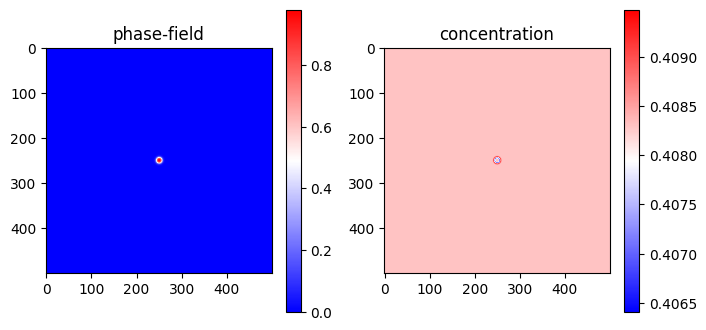

nstep =  100


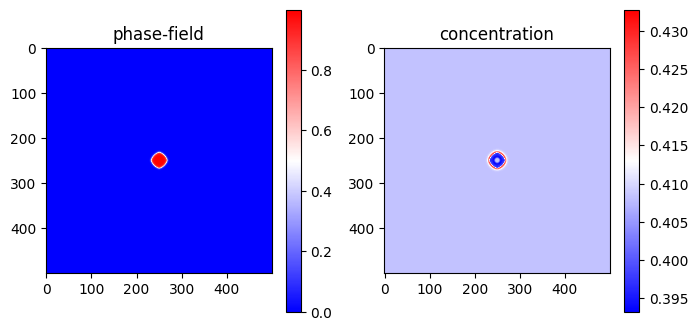

nstep =  200


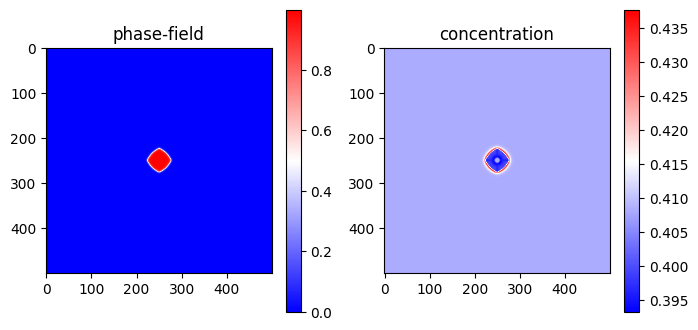

nstep =  300


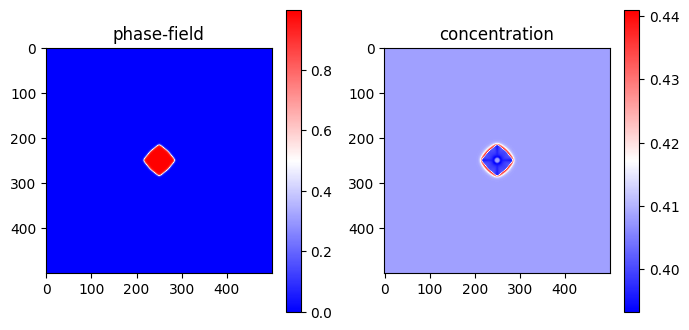

nstep =  400


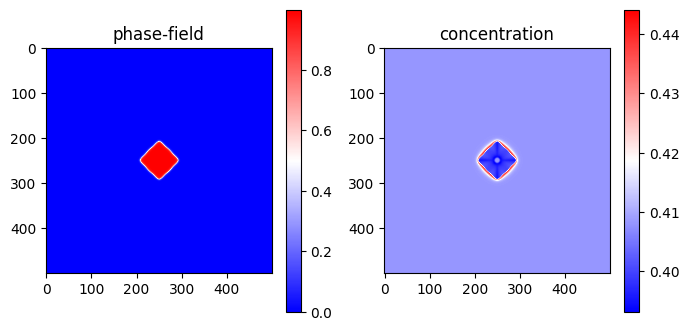

nstep =  500


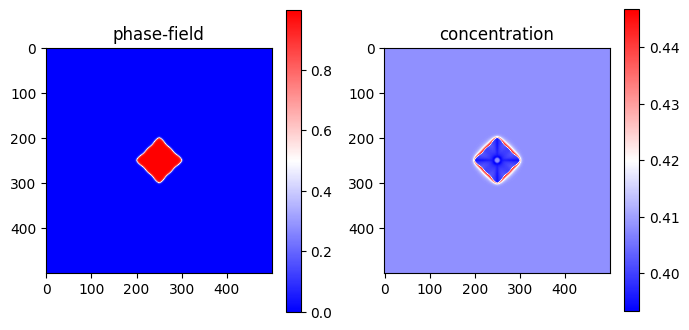

nstep =  600


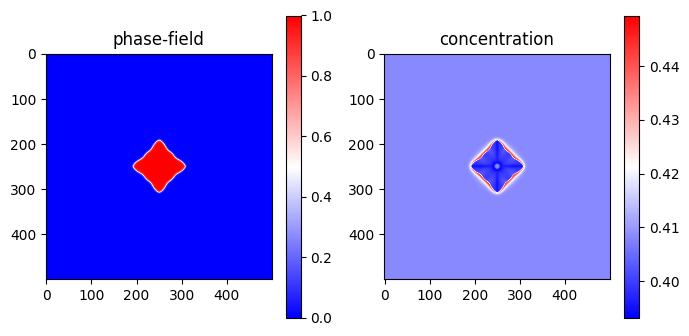

nstep =  700


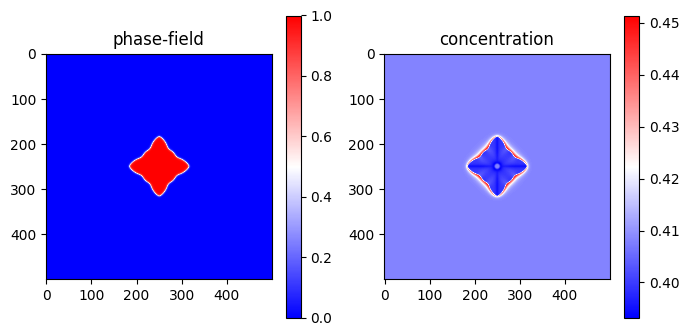

nstep =  800


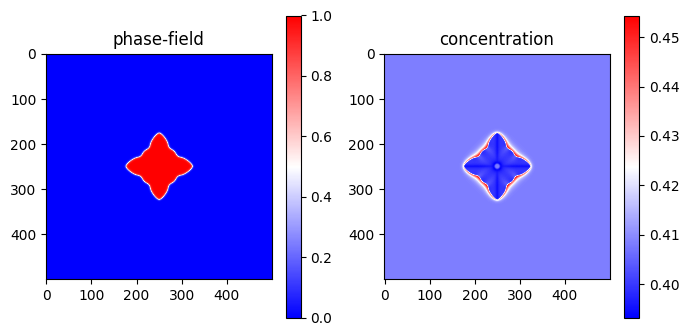

nstep =  900


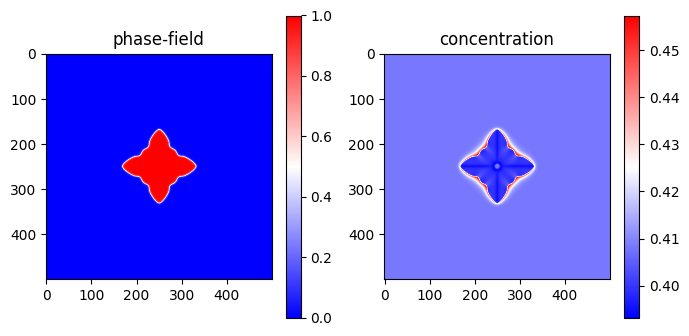

nstep =  1000


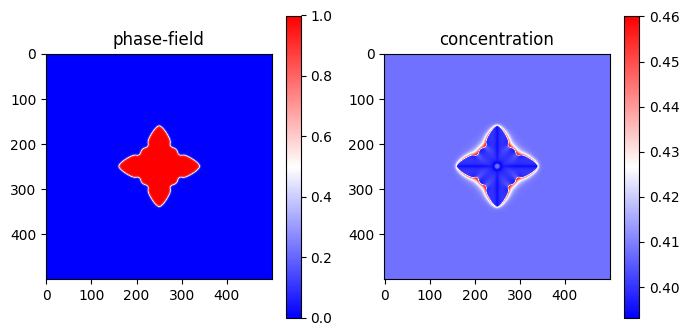

nstep =  1100


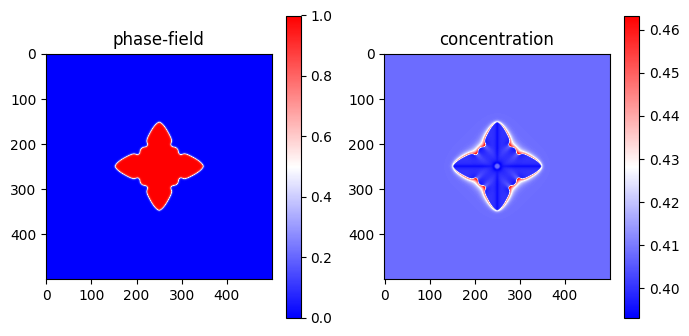

nstep =  1200


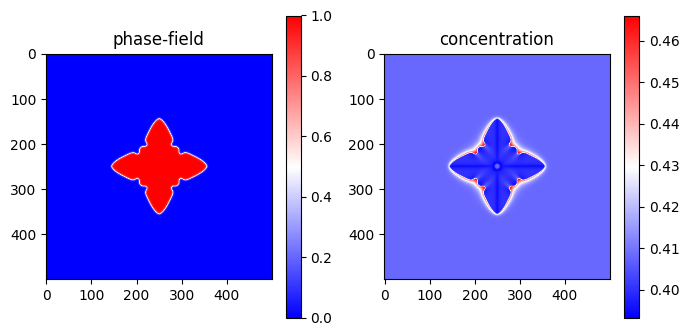

nstep =  1300


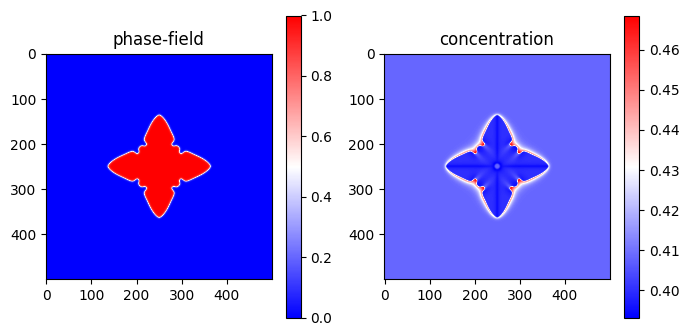

nstep =  1400


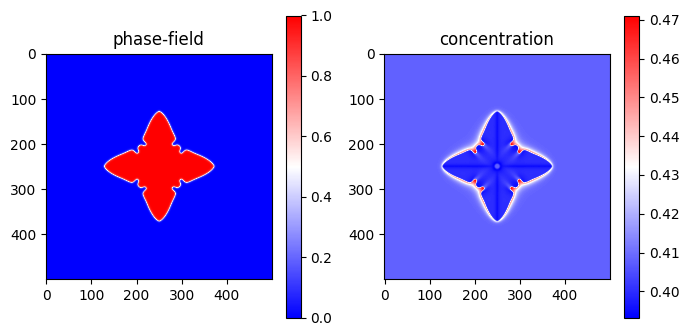

nstep =  1500


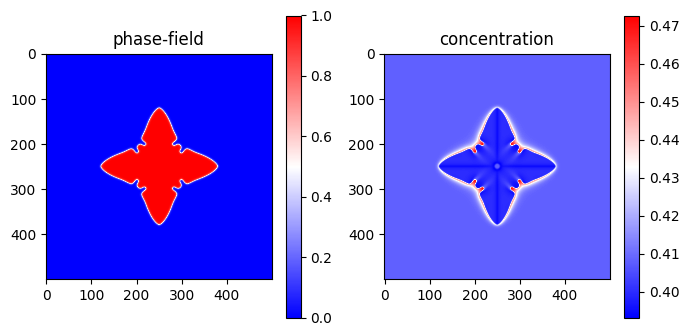

nstep =  1600


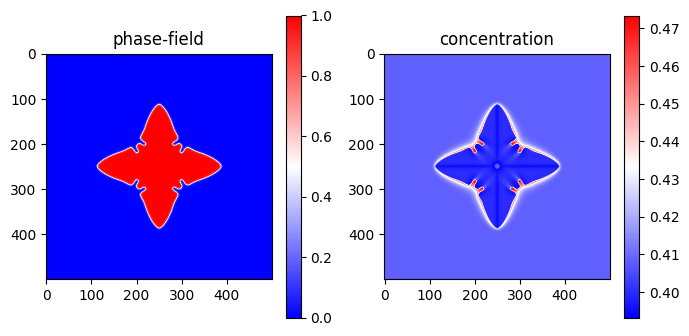

nstep =  1700


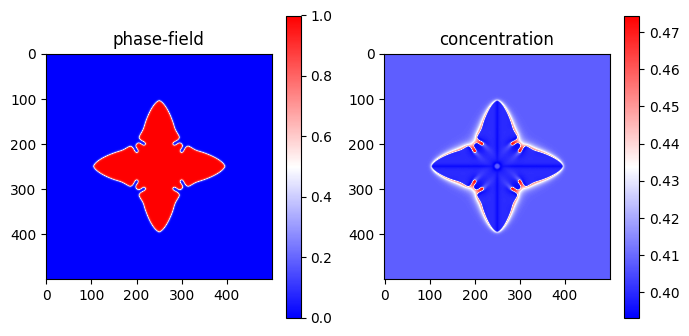

nstep =  1800


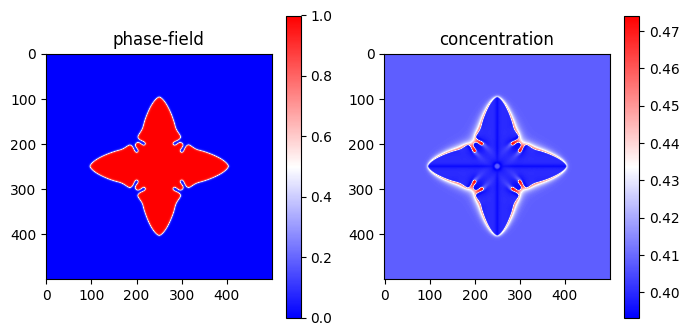

nstep =  1900


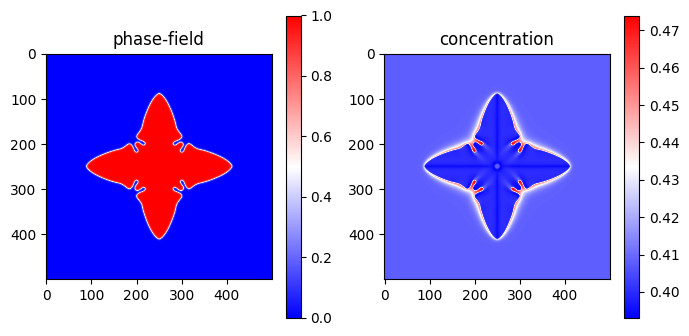

nstep =  2000


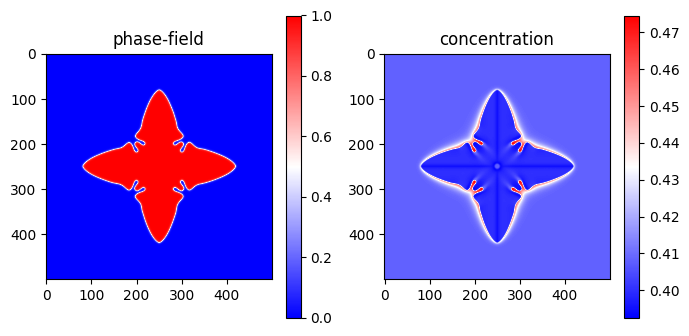

nstep =  2100


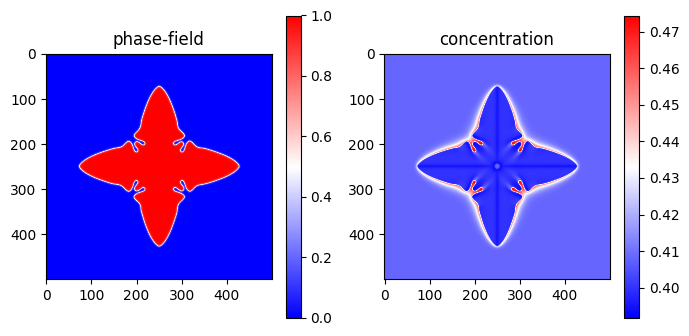

nstep =  2200


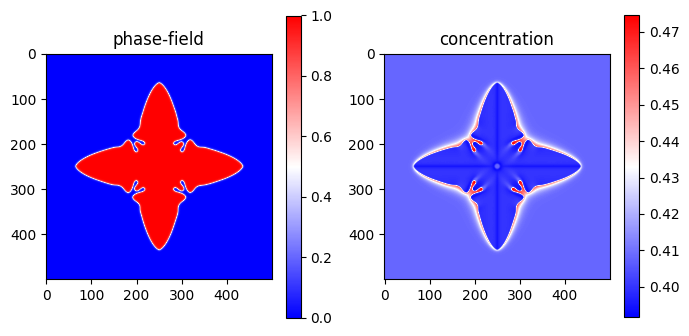

nstep =  2300


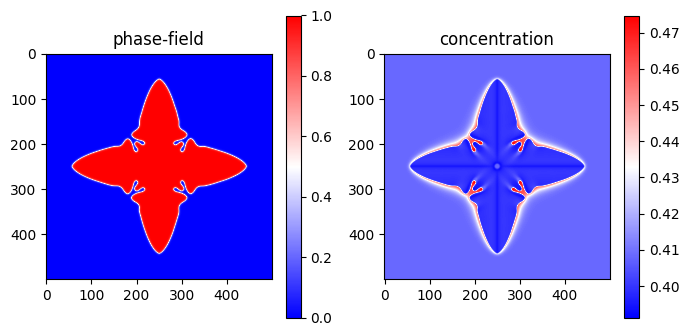

nstep =  2400


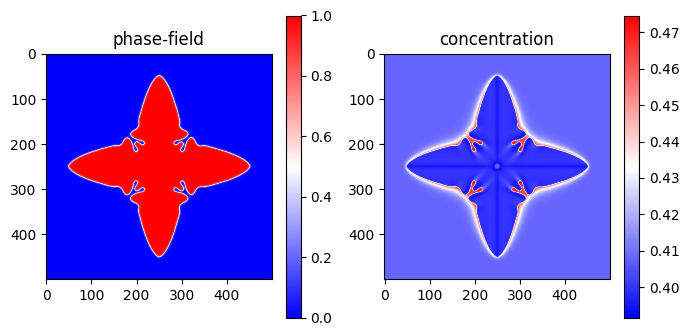

nstep =  2500


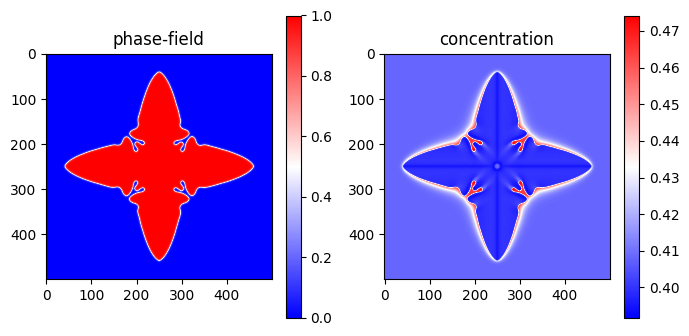

nstep =  2600


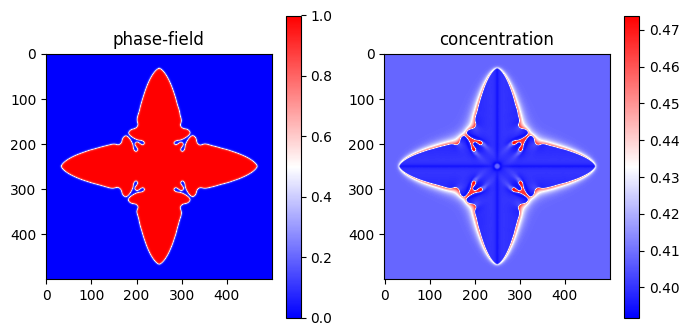

nstep =  2700


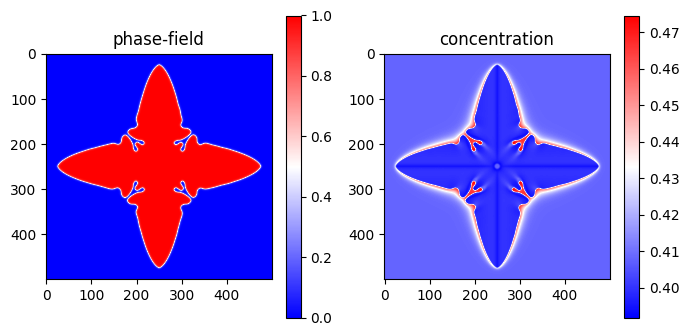

nstep =  2800


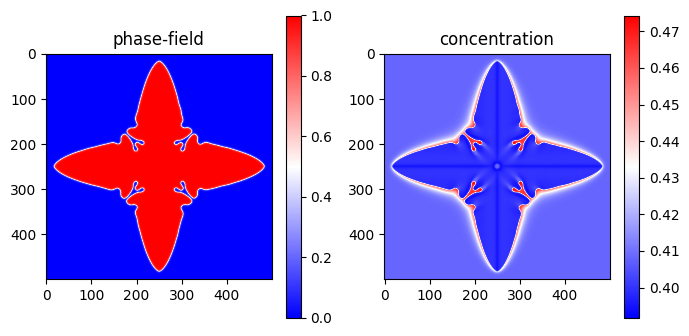

nstep =  2900


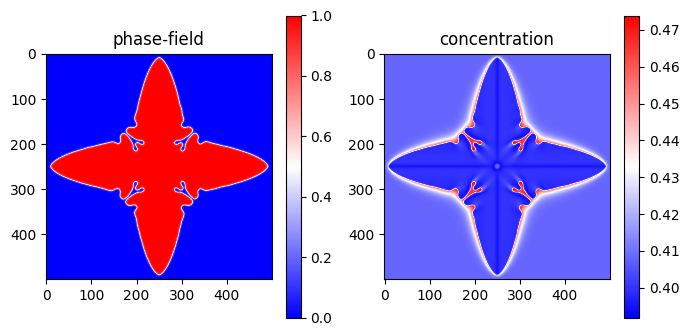

nstep =  3000


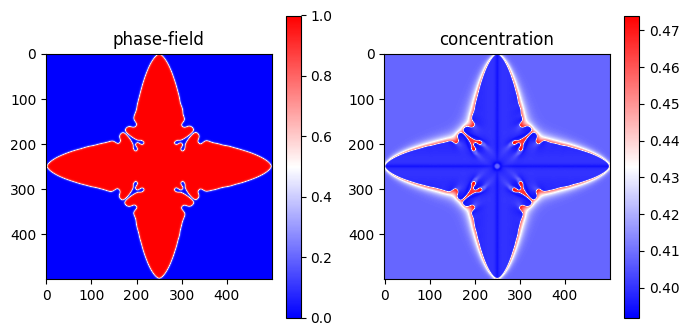

In [11]:
for nstep in range(0,nsteps+1):
  
    calc_gradient(p_t,dpx,dpy)
    solve_allen_cahn(p_t, c_t, dpx, dpy, p_tdt)

    calc_gradient(c_t,dcx,dcy)
    solve_cahn_hilliard(p_t, c_t, dpx, dpy, dcx, dcy, c_tdt)

    p_t[:,:] = p_tdt[:,:]
    c_t[:,:] = c_tdt[:,:]

    if nstep % nout == 0:
        print('nstep = ', nstep)
        fig = plt.figure(figsize=(8,4))
        fig.set_dpi(100)
        plt.subplot(1,2,1)
        plt.imshow(p_t, cmap='bwr')
        plt.title('phase-field')
        plt.colorbar()
        plt.subplot(1,2,2)
        plt.imshow(c_t,cmap='bwr')
        plt.title('concentration')
        plt.colorbar()
        plt.show()